## Practically speaking, we usually start with a target risk, then maximize the return. Hence, the constraints become:

> max<sub>w</sub> μ<sup>T</sup>W

Alternatively,
> max<sub>w</sub> μ<sup>T</sup>W - τw<sup>T</sup>Σw
> <br>
where τ is the Risk-Aversion parameter
> <br>
> <br>
> Subject to w<sup>T</sup>Σw ≤ σ<sup>2</sup>
> <br>
> and 1<sub>D</sub><sup>T</sup>w = 1
> <br>
> (and w<sub>i</sub> ≥ 0, etc...)

In [339]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from scipy.optimize import linprog
from scipy.optimize import minimize

In [366]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)
names = ['GOOG', 'SBUX', 'KSS', 'NEM']
returns = pd.DataFrame()
for name in names:
    returns[name] = df[(df['Name'] == name) & (df.index >= '2014-01-02') & (df.index <= '2014-06-30')].Close.pct_change().dropna()

In [367]:
# Mean return of each stock, also the coefficients of the linear objective function to be minimized.
mean_return = returns.mean()

cov = returns.cov()
cov_np = cov.to_numpy()

# D = Number of asset in porfolio
D = len(mean_return) 
D

4

In [368]:
A_eq = np.ones((1, D))
b_eq = np.ones(1)

### Note: The bounds are by default (0, None) unless otherwise specified.
# bounds = None
bounds = [(-0.5, None)] * D
bounds

[(-0.5, None), (-0.5, None), (-0.5, None), (-0.5, None)]

In [369]:
# minimize
res = linprog(mean_return, A_eq=A_eq,  b_eq=b_eq, bounds=bounds)
res

     con: array([-1.70635128e-09])
     fun: -0.0019527242488783922
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([-0.49999958, -0.49999999,  2.4999991 , -0.49999954])

In [370]:
min_return, max_return = res.fun, -res.fun
print(f"Minimum Return: {min_return * 100}\nMaximum Return: {max_return * 100}")

# Walk through every possible return.
N = 100
target_returns = np.linspace(min_return, max_return, num=N)

Minimum Return: -0.19527242488783922
Maximum Return: 0.19527242488783922


In [371]:
# Objective (variance) that will be minimized. It should return the variance of our portfolio.
def get_portfolio_variance(weights):
    return weights.dot(cov).dot(weights)

# Represent the equality constraint of the target return. It should return zero when the constraint is met.
def target_return_constraint(weights, target):
    # weights.dot(mean_return) = Portfolio Return
    return weights.dot(mean_return) - target

# Represent the portfolio constraint that all weights must sum up to one.
def portfolio_constraint(weights):
    return weights.sum() - 1

In [372]:
constraints = [
    {
        'type': 'eq',                    # Since it's a equality constraint, we pass 'eq' into 'type'.
        'fun': target_return_constraint, # Function that represent our target return constraint
        'args': [target_returns[0]],     # will be updated in loop
    },
    {
        'type': 'eq',                    # Since it's a equality constraint, we pass 'eq' into 'type'.
        'fun': portfolio_constraint,     # Function that represent our portfolio constraint
    }
]

In [373]:
# Without bounds
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D, # uniform, start point array, initial guess for the weights
    method='SLSQP',
    constraints=constraints
)
res

     fun: 0.0013436564477305496
     jac: array([ 0.00025903,  0.00028368,  0.00077974, -0.00097549])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([-0.28283314,  0.42134116,  1.98345652, -1.12196454])

Since the first asset was shorted for over 200%, let's try to apply bounds to the weights.

In [374]:
res = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D,
    method='SLSQP',
    constraints=constraints,
    bounds=bounds
)
res

     fun: 0.0011226587630310684
     jac: array([ 8.53424426e-05,  8.07610340e-05,  8.46259994e-04, -4.25440914e-04])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([-0.5       , -0.49999847,  2.49999847, -0.5       ])

As we can see they are limited by the bounds. We also get a higher variance due to the bounds.

In [375]:
# list to store our risks
optimized_risks = []

# Go through each return to get the efficient frontier
for target in target_returns: 
    # set target return constraint
    constraints[0]['args'] = [target] # 'args': [target_returns[0]], update constraints from target_returns
    
    res = minimize(
              fun=get_portfolio_variance,
              x0=np.ones(D) / D,
              method='SLSQP',
              constraints=constraints,
              bounds=bounds
    )
    optimized_risks.append(np.sqrt(res.fun))
    if res.status != 0:
        print(res)

     fun: 0.0031398628623795716
     jac: array([-0.00039788, -0.00012332, -0.00026107,  0.00235544])
 message: 'Positive directional derivative for linesearch'
    nfev: 21
     nit: 7
    njev: 3
  status: 8
 success: False
       x: array([-0.5, -0.5, -0.5,  2.5])
     fun: 0.0031398628623797616
     jac: array([-0.00039788, -0.00012332, -0.00026107,  0.00235544])
 message: 'Positive directional derivative for linesearch'
    nfev: 298
     nit: 30
    njev: 26
  status: 8
 success: False
       x: array([-0.5, -0.5, -0.5,  2.5])
     fun: 0.003139862862379615
     jac: array([-0.00039788, -0.00012332, -0.00026107,  0.00235544])
 message: 'Positive directional derivative for linesearch'
    nfev: 92
     nit: 13
    njev: 9
  status: 8
 success: False
       x: array([-0.5, -0.5, -0.5,  2.5])


In [396]:
N = 100000
D = len(mean_return)
returns = np.zeros(N)
risks = np.zeros(N)
random_weights = []
for i in range(N):
    rand_range = 1.0
    w = np.random.random(D)*rand_range - rand_range / 2 # with short-selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w)
    random_weights.append(w)
    ret = mean_return.dot(w)
    risk = np.sqrt(w.dot(cov_np).dot(w))
    returns[i] = ret
    risks[i] = risk

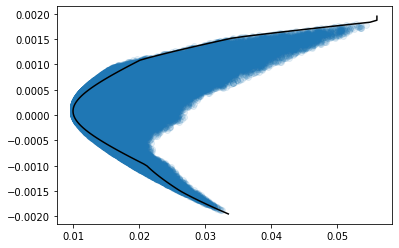

In [397]:
plt.scatter(risks, returns, alpha=0.1);
plt.plot(optimized_risks, target_returns, c='black')
plt.show()

# Global Mimimum Variance (GMV)
To find GMV, we need minimize the 

> min<sub>w</sub> w<sup>T</sup>Σw
<br>
> Subject to 1<sub>D</sub><sup>T</sup>w = 1
<br>
> (and w<sub>i</sub> ≥ 0, etc...)

In [398]:
res = minimize(
    fun=get_portfolio_variance,          # The objective that we minimize is the variance 
    x0=np.ones(D) / D,
    method='SLSQP',
    constraints={
        'type': 'eq',                    # Since it's a equality constraint, we pass 'eq' into 'type'.
        'fun': portfolio_constraint,     # Function that represent our portfolio constraint (All weights sum up to 1)
    },
    bounds=bounds
)
res

     fun: 0.00010178684574496094
     jac: array([0.00018886, 0.000174  , 0.00018463, 0.00026681])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.25, 0.25, 0.25, 0.25])

In [399]:
mv_risk = np.sqrt(res.fun)
mv_weights = res.x
mv_ret = mv_weights.dot(mean_return)

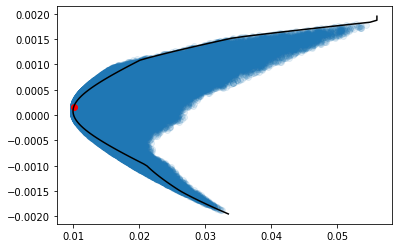

In [400]:
plt.scatter(risks, returns, alpha=.1)
plt.plot(optimized_risks, target_returns, c='black')
plt.scatter([mv_risk], [mv_ret], c='red')
plt.show()

### Sharpe Ratio
Sharpe ratio = Excess return per unit risk

> SR = (E(R<sub>p</sub>) - r<sub>f</sub>) / σ<sub>p</sub>
> <br>
> where r<sub>f</sub> is the Risk-free rate

In practice, risk-free rate is usually set to be the interest rate on the 3-month Treasury Bill (T-Bill) in the US.
<br>
Since the T-Bill is close to zero, risk-free rate is just set to zero.

In [401]:
# Minimize negative sharpe ratio = Maximize sharpe ratio 
def negative_sharpe_ratio(weights):
    mean = weights.dot(mean_return)
    sd = weights.dot(cov).dot(weights)
    return -(mean - risk_free_rate) / sd

In [402]:
# https://fred.stlouisfed.org/series/TB3MS
risk_free_rate = 0.03 / 252 # daily

In [403]:
res = minimize(
    fun=negative_sharpe_ratio, 
    x0=np.ones(D) / D, 
    method='SLSQP', 
    constraints=constraints, 
    bounds=bounds
)
res

     fun: -0.550974580530174
     jac: array([-0.19304433, -0.05334585,  0.12551273,  0.18104838])
 message: 'Positive directional derivative for linesearch'
    nfev: 277
     nit: 30
    njev: 26
  status: 8
 success: False
       x: array([-0.5, -0.5, -0.5,  2.5])

In [404]:
best_w = res.x

In [405]:
# found by optimization
opt_risk = np.sqrt(best_w.dot(cov).dot(best_w))
opt_ret = mean_return.dot(best_w)

In [406]:
mc_best_w = None
mc_best_sr = float('-inf')
for i, (risk, ret) in enumerate(zip(risks, returns)):
    sr = (ret - risk_free_rate) / risk
    if sr > mc_best_sr:
        mc_best_sr = sr
        mc_best_w = random_weights[i]
print(mc_best_w, mc_best_sr)

# found by optimization
opt_risk = np.sqrt(mc_best_w.dot(cov).dot(mc_best_w))
opt_ret = mean_return.dot(mc_best_w)

[ 0.93158922  0.0690331  -0.49287255  0.49225023] 0.05178466901655441


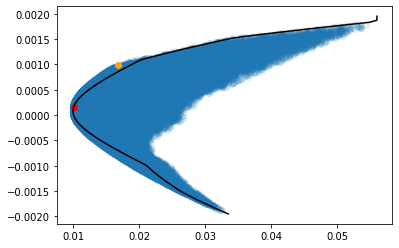

In [407]:
plt.scatter(risks, returns, alpha=.1)
plt.plot(optimized_risks, target_returns, c='black')
plt.scatter([mv_risk], [mv_ret], c='red')
plt.scatter([opt_risk], [opt_ret], c='orange')
plt.show()

# Risk-free asset with tangency portfolio

In [483]:
# Extending the tangency line with linear eq.
m = (opt_ret - risk_free_rate) / (opt_risk - 0) 
c = returns[np.argmin(risks)]
y = m * np.insert(risks, 0, 0) + c

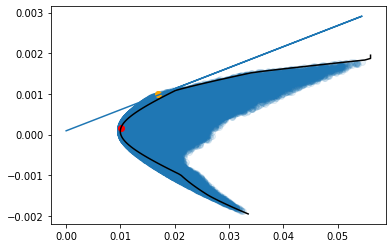

In [486]:
plt.scatter(risks, returns, alpha=.1)
plt.plot(optimized_risks, target_returns, c='black')
plt.scatter([mv_risk], [mv_ret], c='red')
plt.scatter([opt_risk], [opt_ret], c='orange')

# tangent line
plt.plot(np.insert(risks, 0, 0), y)
plt.show()

# Capital Asset Pricing Model (CAPM)
<br>
Tangency Portfolio = Market Portfolio
<br>
Tangency Line = Capital Market Line
<br>
Return: R<sub>M</sub>
<br>
Expected Return: μ<sub>M</sub>
<br>
Risk: σ<sub>M</sub>

CAPM: r<sub>f</sub> + σ(μ<sub>M</sub> - r<sub>f</sub>) / σ<sub>M</sub>
<br>
If Expected Return on Investment < CAPM, then it is not worth to invest, since investing in the market yields higher return for this level of risk.

### Security Market Line (SML)
<br>

> μ<sub>i</sub> - r<sub>f</sub> = β<sub>i</sub>(μ<sub>M</sub> - r<sub>f</sub>)
> <br>
> <br>
> where β<sub>i</sub> is Systematic risk or Market risk
> <br>
> μ<sub>i</sub> - r<sub>f</sub> is Risk premium
> <br>
> μ<sub>M</sub> - r<sub>f</sub> is Market premium (Excess return of the market)
> <br>
> <br>
> Beta tell us how much the asset i moves relative to the market
> <br>
> - β > 1: aggressive
> <br>
> - β = 1: averge risk
> <br>
> - β > 1: not aggressive

According to CAPM, all assets should fall on this line, otherwise it's mispriced.
<br>
If it is above the CAPM, then it is overbought. Otherwise, it's oversell.

### Security Characteristic Line
<br>
- Adds a time index to the SML and remove expected values
<br>

> R<sub>i</sub>(t) - r<sub>f</sub>(t) = β<sub>i</sub>{R<sub>M</sub>(t) - r<sub>f</sub>(t)} + ε<sub>i</sub>(t)
<br>
<br>
- Represent excess returns with a single symbol (denoted by '):
<br>
<br>

> R<sub>i</sub>'(t) = β<sub>i</sub>R<sub>M</sub>'(t) + ε<sub>i</sub>(t)

### Including Alpha
<br>

> R<sub>i</sub>'(t) = α<sub>i</sub> + β<sub>i</sub>R<sub>M</sub>'(t) + ε<sub>i</sub>(t)
> <br>
> <br>
> where α<sub>i</sub> is the excess return 
> <br>
> If α != 0, the security is mispriced
> If α > 0, the security is underpriced
> - The returns have been too large on average
> - This is a "buy" signal

### Assumptions of CAPM (That's not true):

- Markets are in equilibrium (supply equals demand)
- Every investor has the same forecasts of returns and risks
- Every investor is a mean-variance optimizer (holds a combination of tangency portfolio and risk-free asset)
- Since the tangency portfolio is held by every investors under this model, it becomes the market portfolio 

### Problems with Modern Portfolio Theory
<br>
- We don't know the expected return / covariance 
<br>
- We have two approaches:
<br>

> 1) Estimate based on historical returns
<br>
> > a) Sounds bad, but not uncommon
<br>
b) Common advanced techniques are based on this
<br>

> 2) Use machine learning
<br>
> > a) May include all kinds of data on top of returns (fundamentals, public, private)
<br>
b) Important to test whether it performs better than baseline
<br>

### Robust Estimation Techniques:
<br>
1) Boostrapping
<br>
2) Shrinkage Estimation
<br>
3) Black-Litterman
<br>